## 1. Import the Dataset

In [1]:
import pandas as pd
df = pd.read_xml('../input/stackexchange/PostHistory.xml')
df.head()

Id  PostHistoryTypeId  PostId                          RevisionGUID  \
0   7                  2       5  009bca93-fce2-44ed-a277-a8452650a627   
1   8                  1       5  009bca93-fce2-44ed-a277-a8452650a627   
2   9                  3       5  009bca93-fce2-44ed-a277-a8452650a627   
3  12                  2       7  ea5a5642-ed30-43ea-9be5-8e8de0e1c660   
4  13                  1       7  ea5a5642-ed30-43ea-9be5-8e8de0e1c660   

              CreationDate  UserId  \
0  2014-05-13T23:58:30.457     5.0   
1  2014-05-13T23:58:30.457     5.0   
2  2014-05-13T23:58:30.457     5.0   
3  2014-05-14T00:11:06.457    36.0   
4  2014-05-14T00:11:06.457    36.0   

                                                Text ContentLicense Comment  \
0  I've always been interested in machine learnin...   CC BY-SA 3.0    None   
1  How can I do simple machine learning without h...   CC BY-SA 3.0    None   
2                                 <machine-learning>   CC BY-SA 3.0    None   
3  As a researcher and instructor, I'm looking fo...   CC BY-SA 3.0    None   
4  What open-source books (or other materials) pr...   CC BY-SA 3.0    None   

  UserDisplayName  
0            None  
1            None  
2            None  
3            None  
4            None

In [2]:
df.shape

(222493, 10)

In [3]:
df = df.drop_duplicates(subset=['Text'], keep='first')

In [4]:
df.shape

(165773, 10)

In [5]:
df.reset_index(drop=True, inplace=True)

In [6]:
df.Text[800]

'Online k-means (more commonly known as [sequential k-means](http://stackoverflow.com/questions/3698532/online-k-means-clustering)) and traditional k-means are very similar.  The difference is that online k-means allows you to update the model as new data is received.\r\n\r\nOnline k-means should be used when you expect the data to be received one by one (or maybe in chunks).  This allows you to update your model as you get more information about it.  The drawback of this method is that it is dependent on the order in which the data is received ([ref](http://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/C/sk_means.htm)).  '

In [8]:
df = df.sample(n=10000, random_state=42)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(10000, 10)

## 2. Import Packages

In [11]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
!pip install pyLDAvis

In [13]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
#import pyLDAvis.gensim_models # don't skip this
import pyLDAvis.gensim



import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [14]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [15]:
len(stop_words)

221

## 3. Tokenize Sentences and Clean

In [16]:
# Convert to list
df['Text']= df['Text'].apply(str)

data = df.Text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I have salary data of several user (Python list) ? Now I am using KMeans to '
 'cluster them. Given this data, Is there a way to figure out the best value '
 'for K automatically through program ? I tried silhouette analysis: '
 'http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html '
 'take k with highest silhouette_avg score. Is this the best way ? ']


In [17]:
pprint(data[800])

'How to handle non-numeric user ids in a recommendation model'


In [18]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['have', 'salary', 'data', 'of', 'several', 'user', 'python', 'list', 'now', 'am', 'using', 'kmeans', 'to', 'cluster', 'them', 'given', 'this', 'data', 'is', 'there', 'way', 'to', 'figure', 'out', 'the', 'best', 'value', 'for', 'automatically', 'through', 'program', 'tried', 'silhouette', 'analysis', 'http', 'scikit', 'learn', 'org', 'stable', 'auto_examples', 'cluster', 'html', 'take', 'with', 'highest', 'silhouette_avg', 'score', 'is', 'this', 'the', 'best', 'way']]


In [19]:
!pip install -U spacy

     |████████████████████████████████| 6.0 MB 878 kB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.3
    Uninstalling spacy-3.2.3:
      Successfully uninstalled spacy-3.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typi

In [20]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 7.9 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


## 4. Build the Bigram, Trigram Models and Lemmatize

In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [23]:
pprint(data_ready[800])

['handle', 'numeric', 'user', 'model']


## 5. Create the Dictionary and Corpus needed for Topic Modeling

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus
texts = data_ready

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



## 6. Find the optimal number of topics for LDA

In [24]:
def compute_coherence_values_LDA(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
model_list, coherence_values = compute_coherence_values_LDA(dictionary=id2word, corpus=corpus, texts=data_ready, start=3, limit=10, step=1)

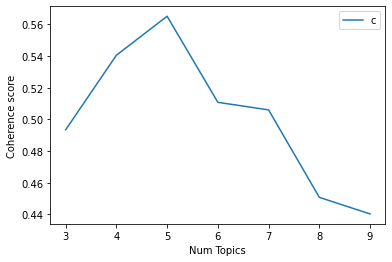

In [33]:
limit=10; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4934
Num Topics = 4  has Coherence Value of 0.5405
Num Topics = 5  has Coherence Value of 0.5651
Num Topics = 6  has Coherence Value of 0.5108
Num Topics = 7  has Coherence Value of 0.506
Num Topics = 8  has Coherence Value of 0.4507
Num Topics = 9  has Coherence Value of 0.4403


the number of topics we will applied is 6 topics 

## 7. Build the Topic Model based on the entire dataset

In [35]:
df = pd.read_xml('../input/stackexchange/PostHistory.xml')
df.head()

Id  PostHistoryTypeId  PostId                          RevisionGUID  \
0   7                  2       5  009bca93-fce2-44ed-a277-a8452650a627   
1   8                  1       5  009bca93-fce2-44ed-a277-a8452650a627   
2   9                  3       5  009bca93-fce2-44ed-a277-a8452650a627   
3  12                  2       7  ea5a5642-ed30-43ea-9be5-8e8de0e1c660   
4  13                  1       7  ea5a5642-ed30-43ea-9be5-8e8de0e1c660   

              CreationDate  UserId  \
0  2014-05-13T23:58:30.457     5.0   
1  2014-05-13T23:58:30.457     5.0   
2  2014-05-13T23:58:30.457     5.0   
3  2014-05-14T00:11:06.457    36.0   
4  2014-05-14T00:11:06.457    36.0   

                                                Text ContentLicense Comment  \
0  I've always been interested in machine learnin...   CC BY-SA 3.0    None   
1  How can I do simple machine learning without h...   CC BY-SA 3.0    None   
2                                 <machine-learning>   CC BY-SA 3.0    None   
3  As a researcher and instructor, I'm looking fo...   CC BY-SA 3.0    None   
4  What open-source books (or other materials) pr...   CC BY-SA 3.0    None   

  UserDisplayName  
0            None  
1            None  
2            None  
3            None  
4            None

In [36]:
df = df.drop_duplicates(subset=['Text'], keep='first')

In [37]:
df.reset_index(drop=True, inplace=True)

In [38]:
# Convert to list
df['Text']= df['Text'].apply(str)

data = df.Text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Ive always been interested in machine learning, but I cant figure out one '
 'thing about starting out with a simple "Hello World" example - how can I '
 'avoid hard-coding behavior? For example, if I wanted to "teach" a bot how to '
 'avoid randomly placed obstacles, I couldnt just use relative motion, because '
 'the obstacles move around, but I dont want to hard code, say, distance, '
 'because that ruins the whole point of machine learning. Obviously, randomly '
 'generating code would be impractical, so how could I do this?']


In [39]:
data_words = list(sent_to_words(data))

print(data_words[:1])

[['ive', 'always', 'been', 'interested', 'in', 'machine', 'learning', 'but', 'cant', 'figure', 'out', 'one', 'thing', 'about', 'starting', 'out', 'with', 'simple', 'hello', 'world', 'example', 'how', 'can', 'avoid', 'hard', 'coding', 'behavior', 'for', 'example', 'if', 'wanted', 'to', 'teach', 'bot', 'how', 'to', 'avoid', 'randomly', 'placed', 'obstacles', 'couldnt', 'just', 'use', 'relative', 'motion', 'because', 'the', 'obstacles', 'move', 'around', 'but', 'dont', 'want', 'to', 'hard', 'code', 'say', 'distance', 'because', 'that', 'ruins', 'the', 'whole', 'point', 'of', 'machine', 'learning', 'obviously', 'randomly', 'generating', 'code', 'would', 'be', 'impractical', 'so', 'how', 'could', 'do', 'this']]


In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=30, threshold=200) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=150)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [41]:
data_ready = process_words(data_words)  # processed Text Data!

In [42]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.063*"model" + 0.044*"self" + 0.027*"function" + 0.027*"loss" + '
  '0.020*"sequence" + 0.019*"value" + 0.019*"probability" + 0.018*"true" + '
  '0.017*"shape" + 0.017*"sample"'),
 (1,
  '0.032*"model" + 0.029*"datum" + 0.020*"feature" + 0.014*"class" + '
  '0.014*"set" + 0.012*"train" + 0.011*"text" + 0.011*"dataset" + '
  '0.011*"example" + 0.011*"question"'),
 (2,
  '0.044*"import" + 0.040*"predict" + 0.037*"label" + 0.034*"vector" + '
  '0.031*"classification" + 0.026*"regression" + 0.025*"random" + 0.024*"test" '
  '+ 0.022*"x_train" + 0.020*"sklearn"'),
 (3,
  '0.079*"layer" + 0.073*"learn" + 0.049*"network" + 0.036*"add" + '
  '0.034*"lstm" + 0.028*"machine" + 0.024*"learning" + 0.023*"validation" + '
  '0.023*"kera" + 0.017*"deep"'),
 (4,
  '0.052*"output" + 0.048*"input" + 0.034*"image" + 0.031*"embed" + '
  '0.023*"sentence" + 0.023*"point" + 0.022*"neural" + 0.020*"metric" + '
  '0.019*"target" + 0.019*"sum"'),
 (5,
  '0.040*"value" + 0.035*"datum" + 0.031*"column" 

## 8. the Dominant topic and its percentage contribution in each document

In [44]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             4.0              0.5257   
1            1             3.0              0.5655   
2            2             3.0              0.7222   
3            3             1.0              0.8625   
4            4             1.0              0.7200   
5            5             1.0              0.8781   
6            6             3.0              0.7125   
7            7             1.0              0.9425   
8            8             1.0              0.8332   
9            9             1.0              0.7222   

                                            Keywords  \
0  output, input, image, embed, sentence, point, ...   
1  layer, learn, network, add, lstm, machine, lea...   
2  layer, learn, network, add, lstm, machine, lea...   
3  model, datum, feature, class, set, train, text...   
4  model, datum, feature, class, set, train, text...   
5  model, datum, feature, class, set, train, text...   
6  layer, learn, network, add, lstm, machine, lea...   
7  model, datum, feature, class, set, train, text...   
8  model, datum, feature, class, set, train, text...   
9  model, datum, feature, class, set, train, text...   

                                                Text  
0  [always, interested, machine, learning, figure...  
1     [simple, machine, learn, hard, code, behavior]  
2                                [machine, learning]  
3  [researcher, instructor, look, open, source, b...  
4  [open, source, book, material, provide, relati...  
5  [sure, fit, scope, ai, approach, decide, model...  
6  [book, element, statistical, learn, friedman, ...  
7  [sure, data, science, discuss, forum, several,...  
8                     [data, science, datum, mining]  
9                                     [data, mining]

## 9. The most representative sentence for each topic

In [45]:

# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9547   
1        1.0              0.9747   
2        2.0              0.8958   
3        3.0              0.9165   
4        4.0              0.8608   
5        5.0              0.9429   

                                                                                     Keywords  \
0              model, self, function, loss, sequence, value, probability, true, shape, sample   
1                  model, datum, feature, class, set, train, text, dataset, example, question   
2  import, predict, label, vector, classification, regression, random, test, x_train, sklearn   
3                 layer, learn, network, add, lstm, machine, learning, validation, kera, deep   
4                   output, input, image, embed, sentence, point, neural, metric, target, sum   
5                            value, datum, column, time, df, row, list, variable, name, index   

                                                                                   Representative Text  
0  [train, new, dataset, usually, accuracy, steadily, improve, epoch, create, new, similar, dataset...  
1  [split, combination, prediction, fish, chip, first, choice, fish, chip, top, choice, well, idea,...  
2                               [classification, random, forest, logistic, regression, decision, tree]  
3                             [online, course, machine, learn, course, coursera, book, machine, learn]  
4                                                                [find, close, facet, construct, hull]  
5  [df, df, df, index, nat, df, isnull, df, df, isnull, notnull, set_index, df, index, paid_date_na...

## 10. Frequency Distribution of Word Counts in Documents

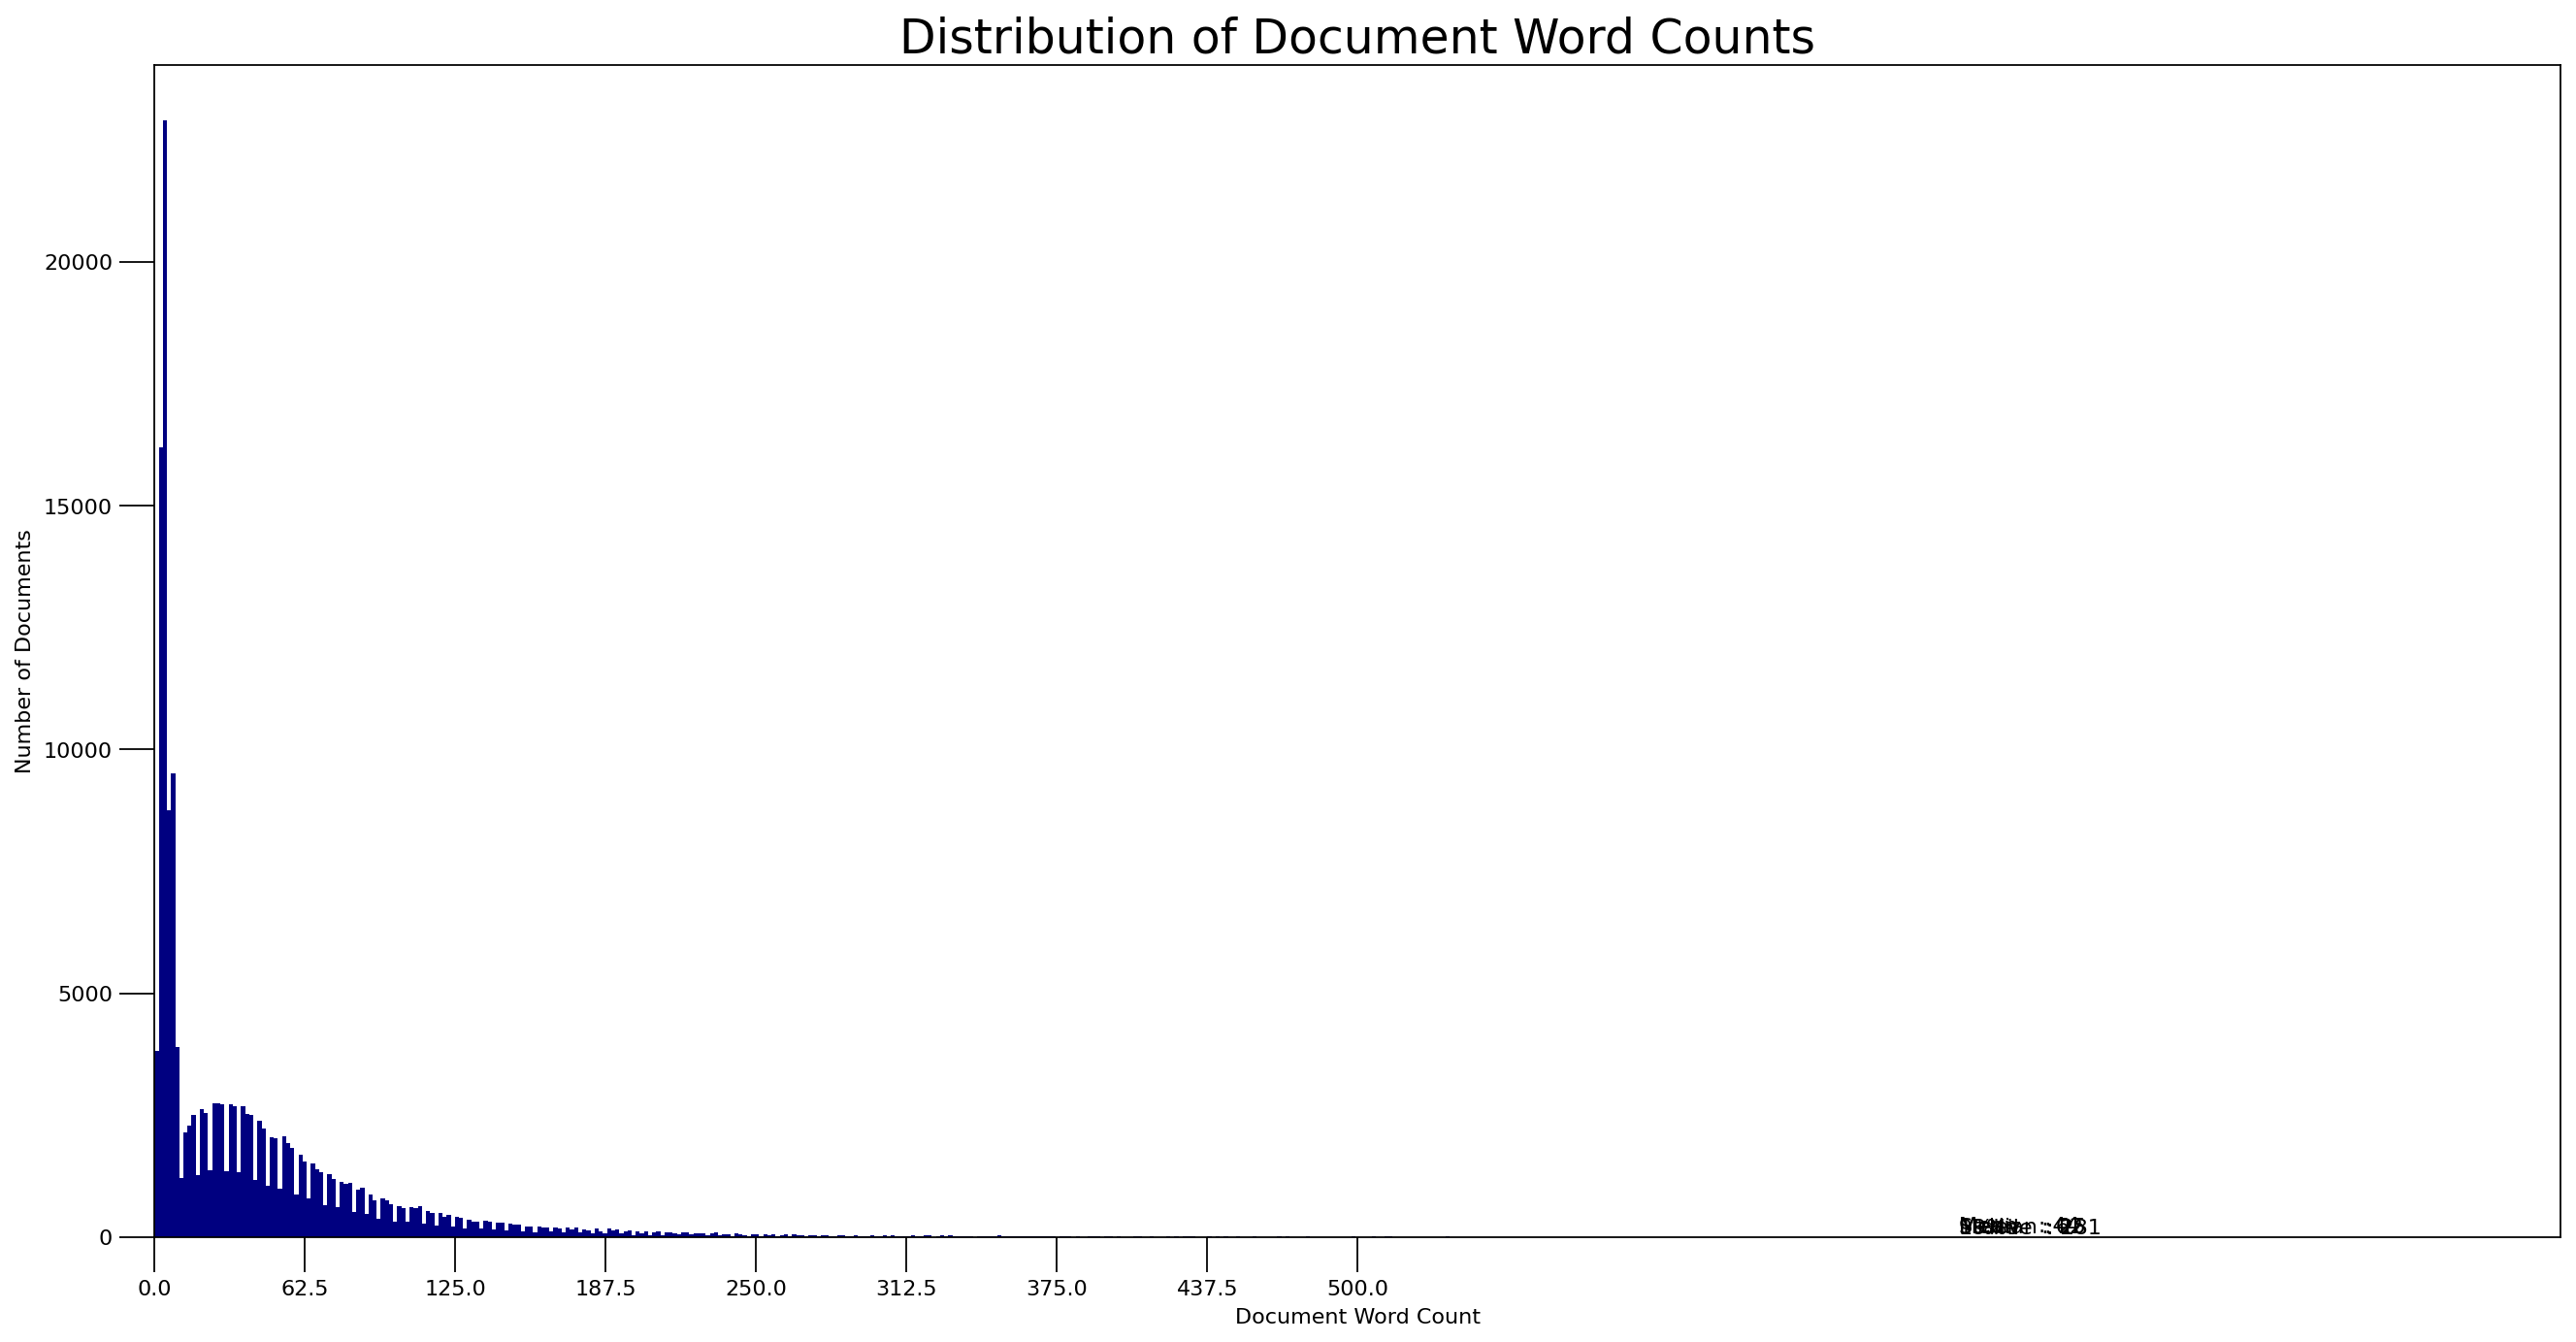

In [46]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(20,10), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

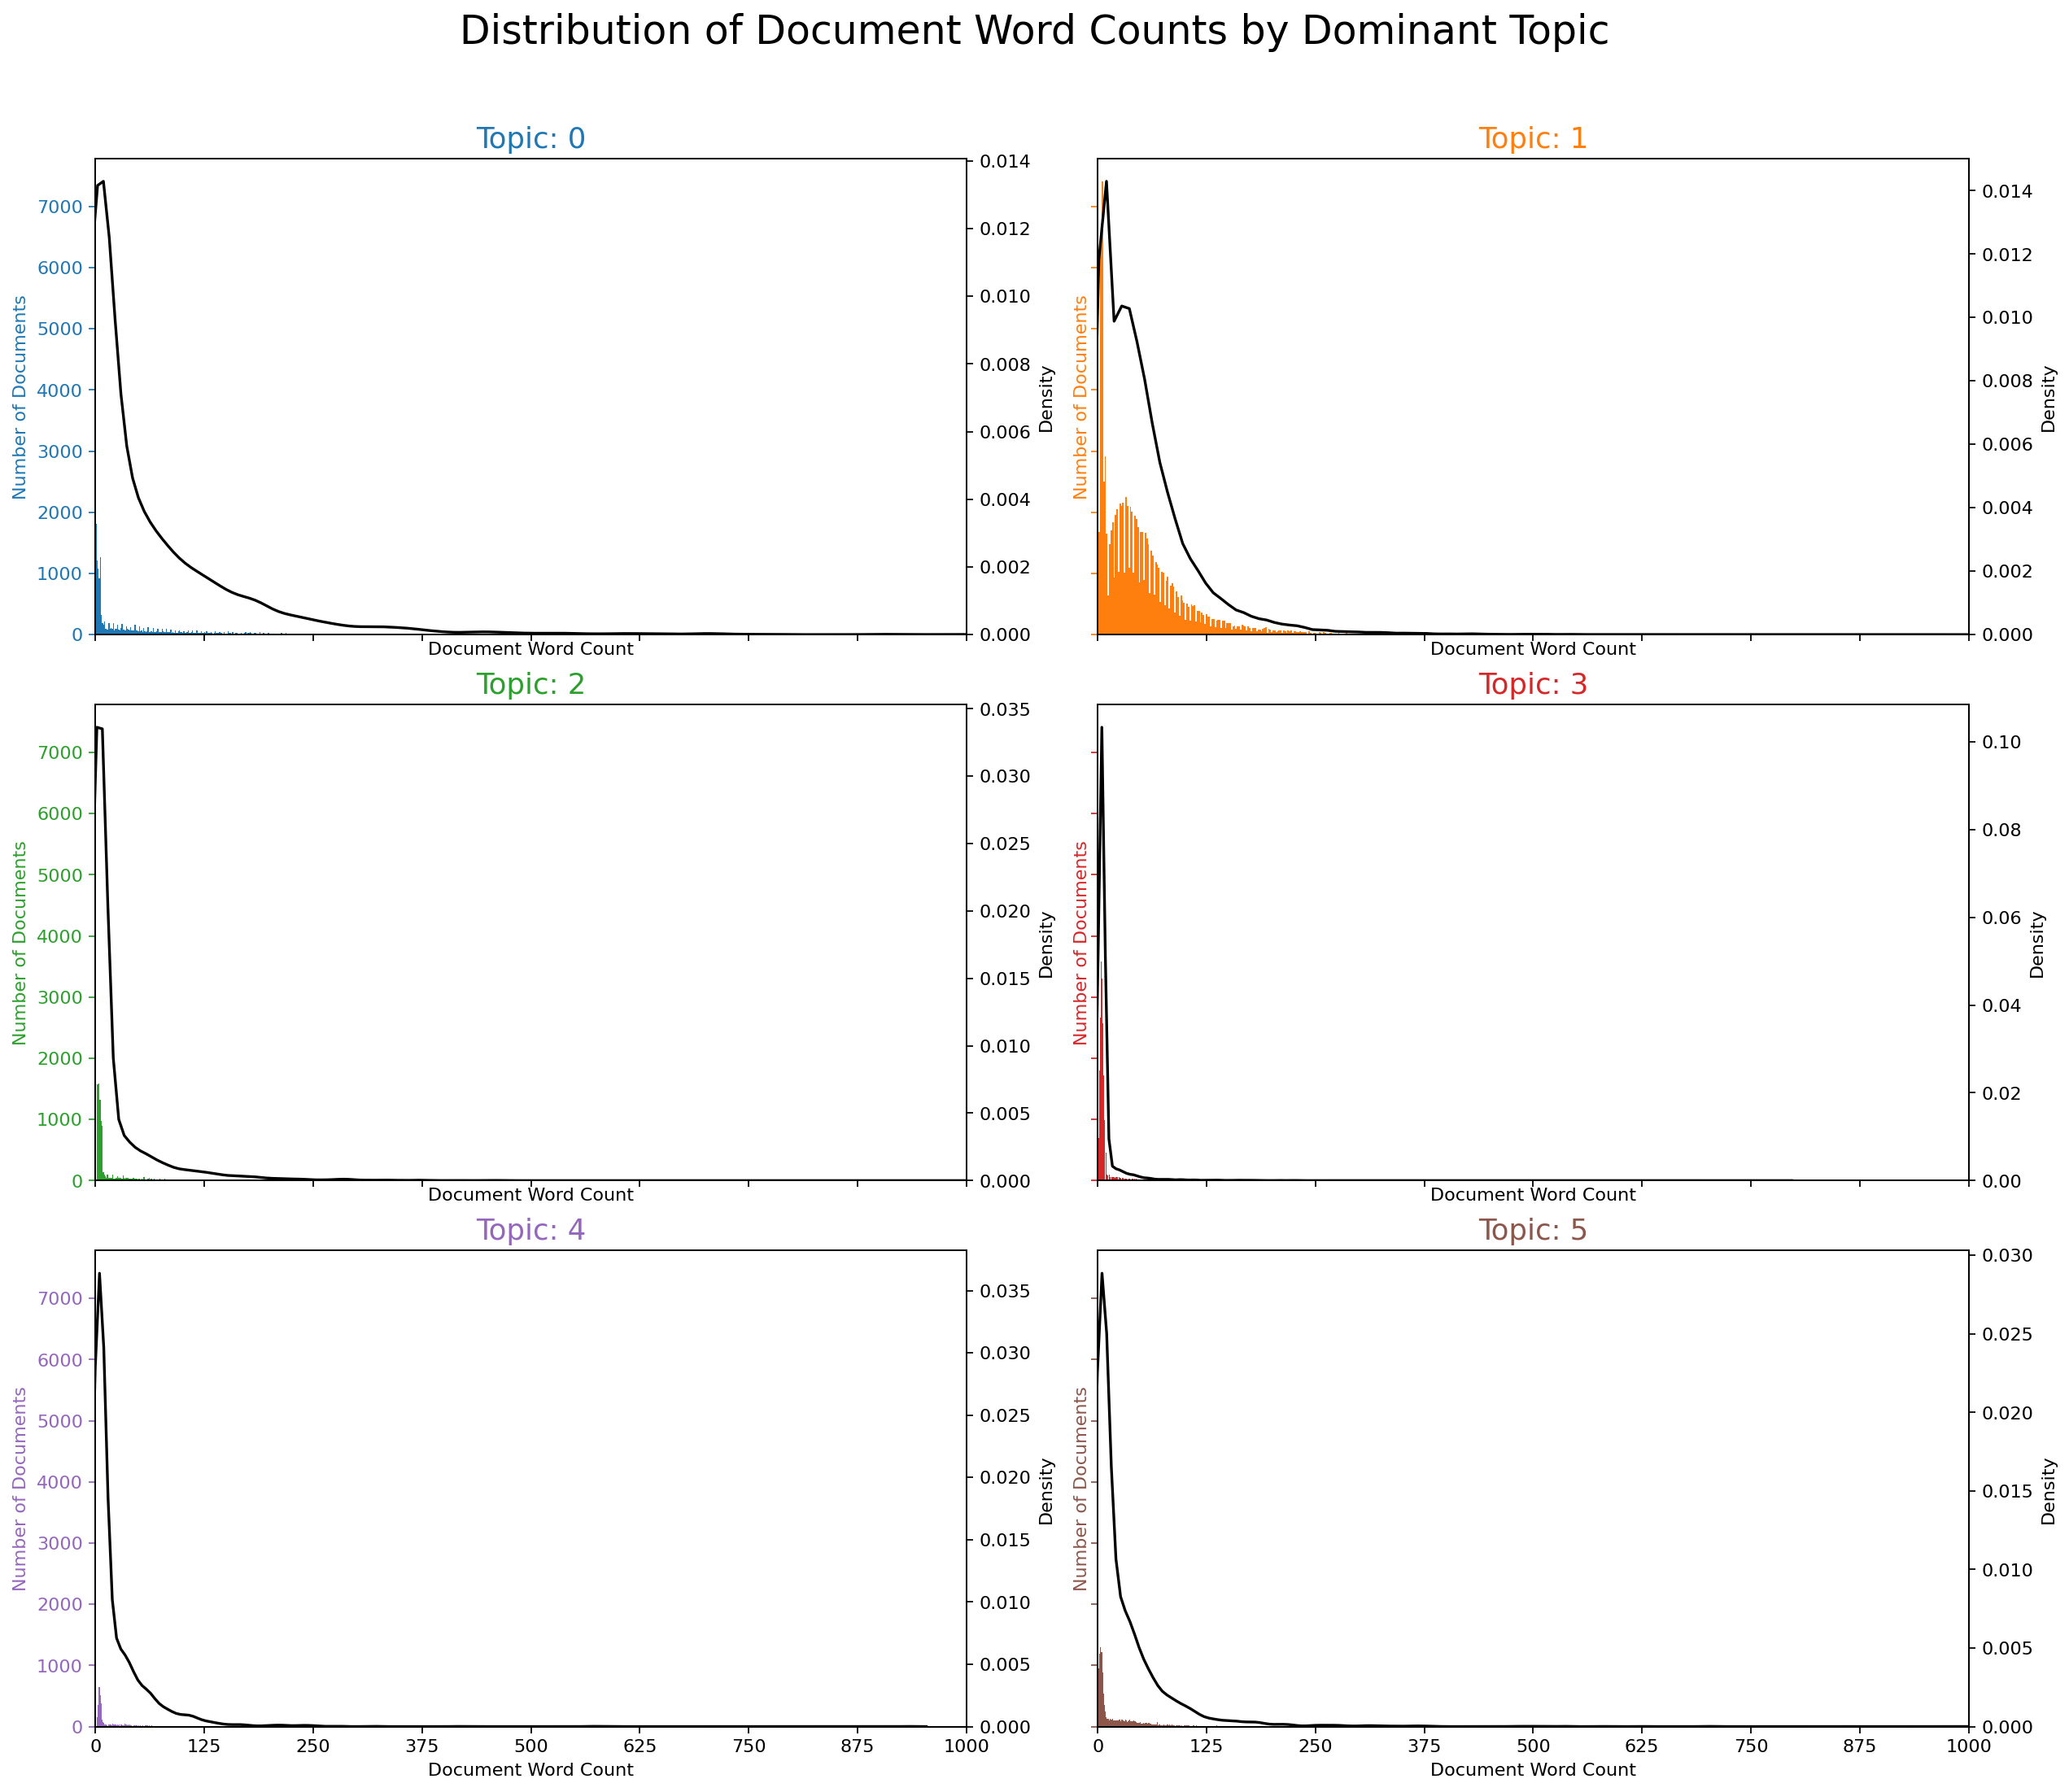

In [47]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## 11. Word Clouds of Top N Keywords in Each Topic.

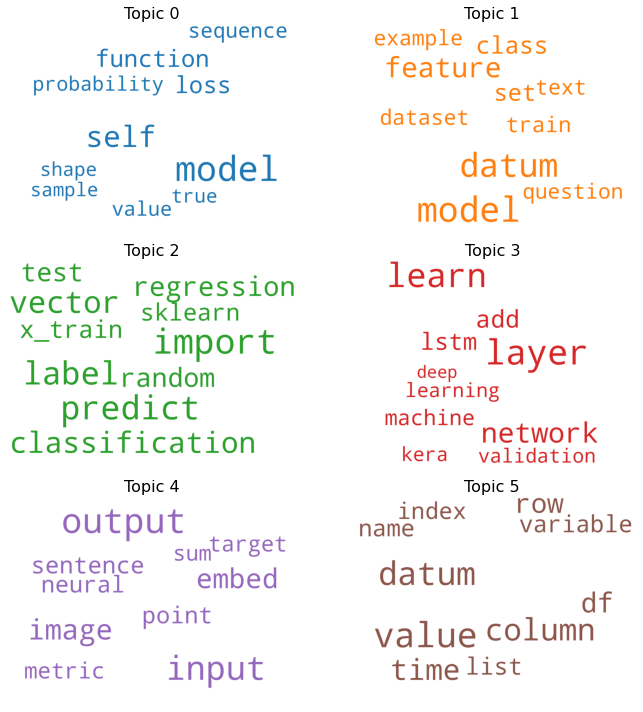

In [48]:

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


## 12. Word Counts of Topic Keywords

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


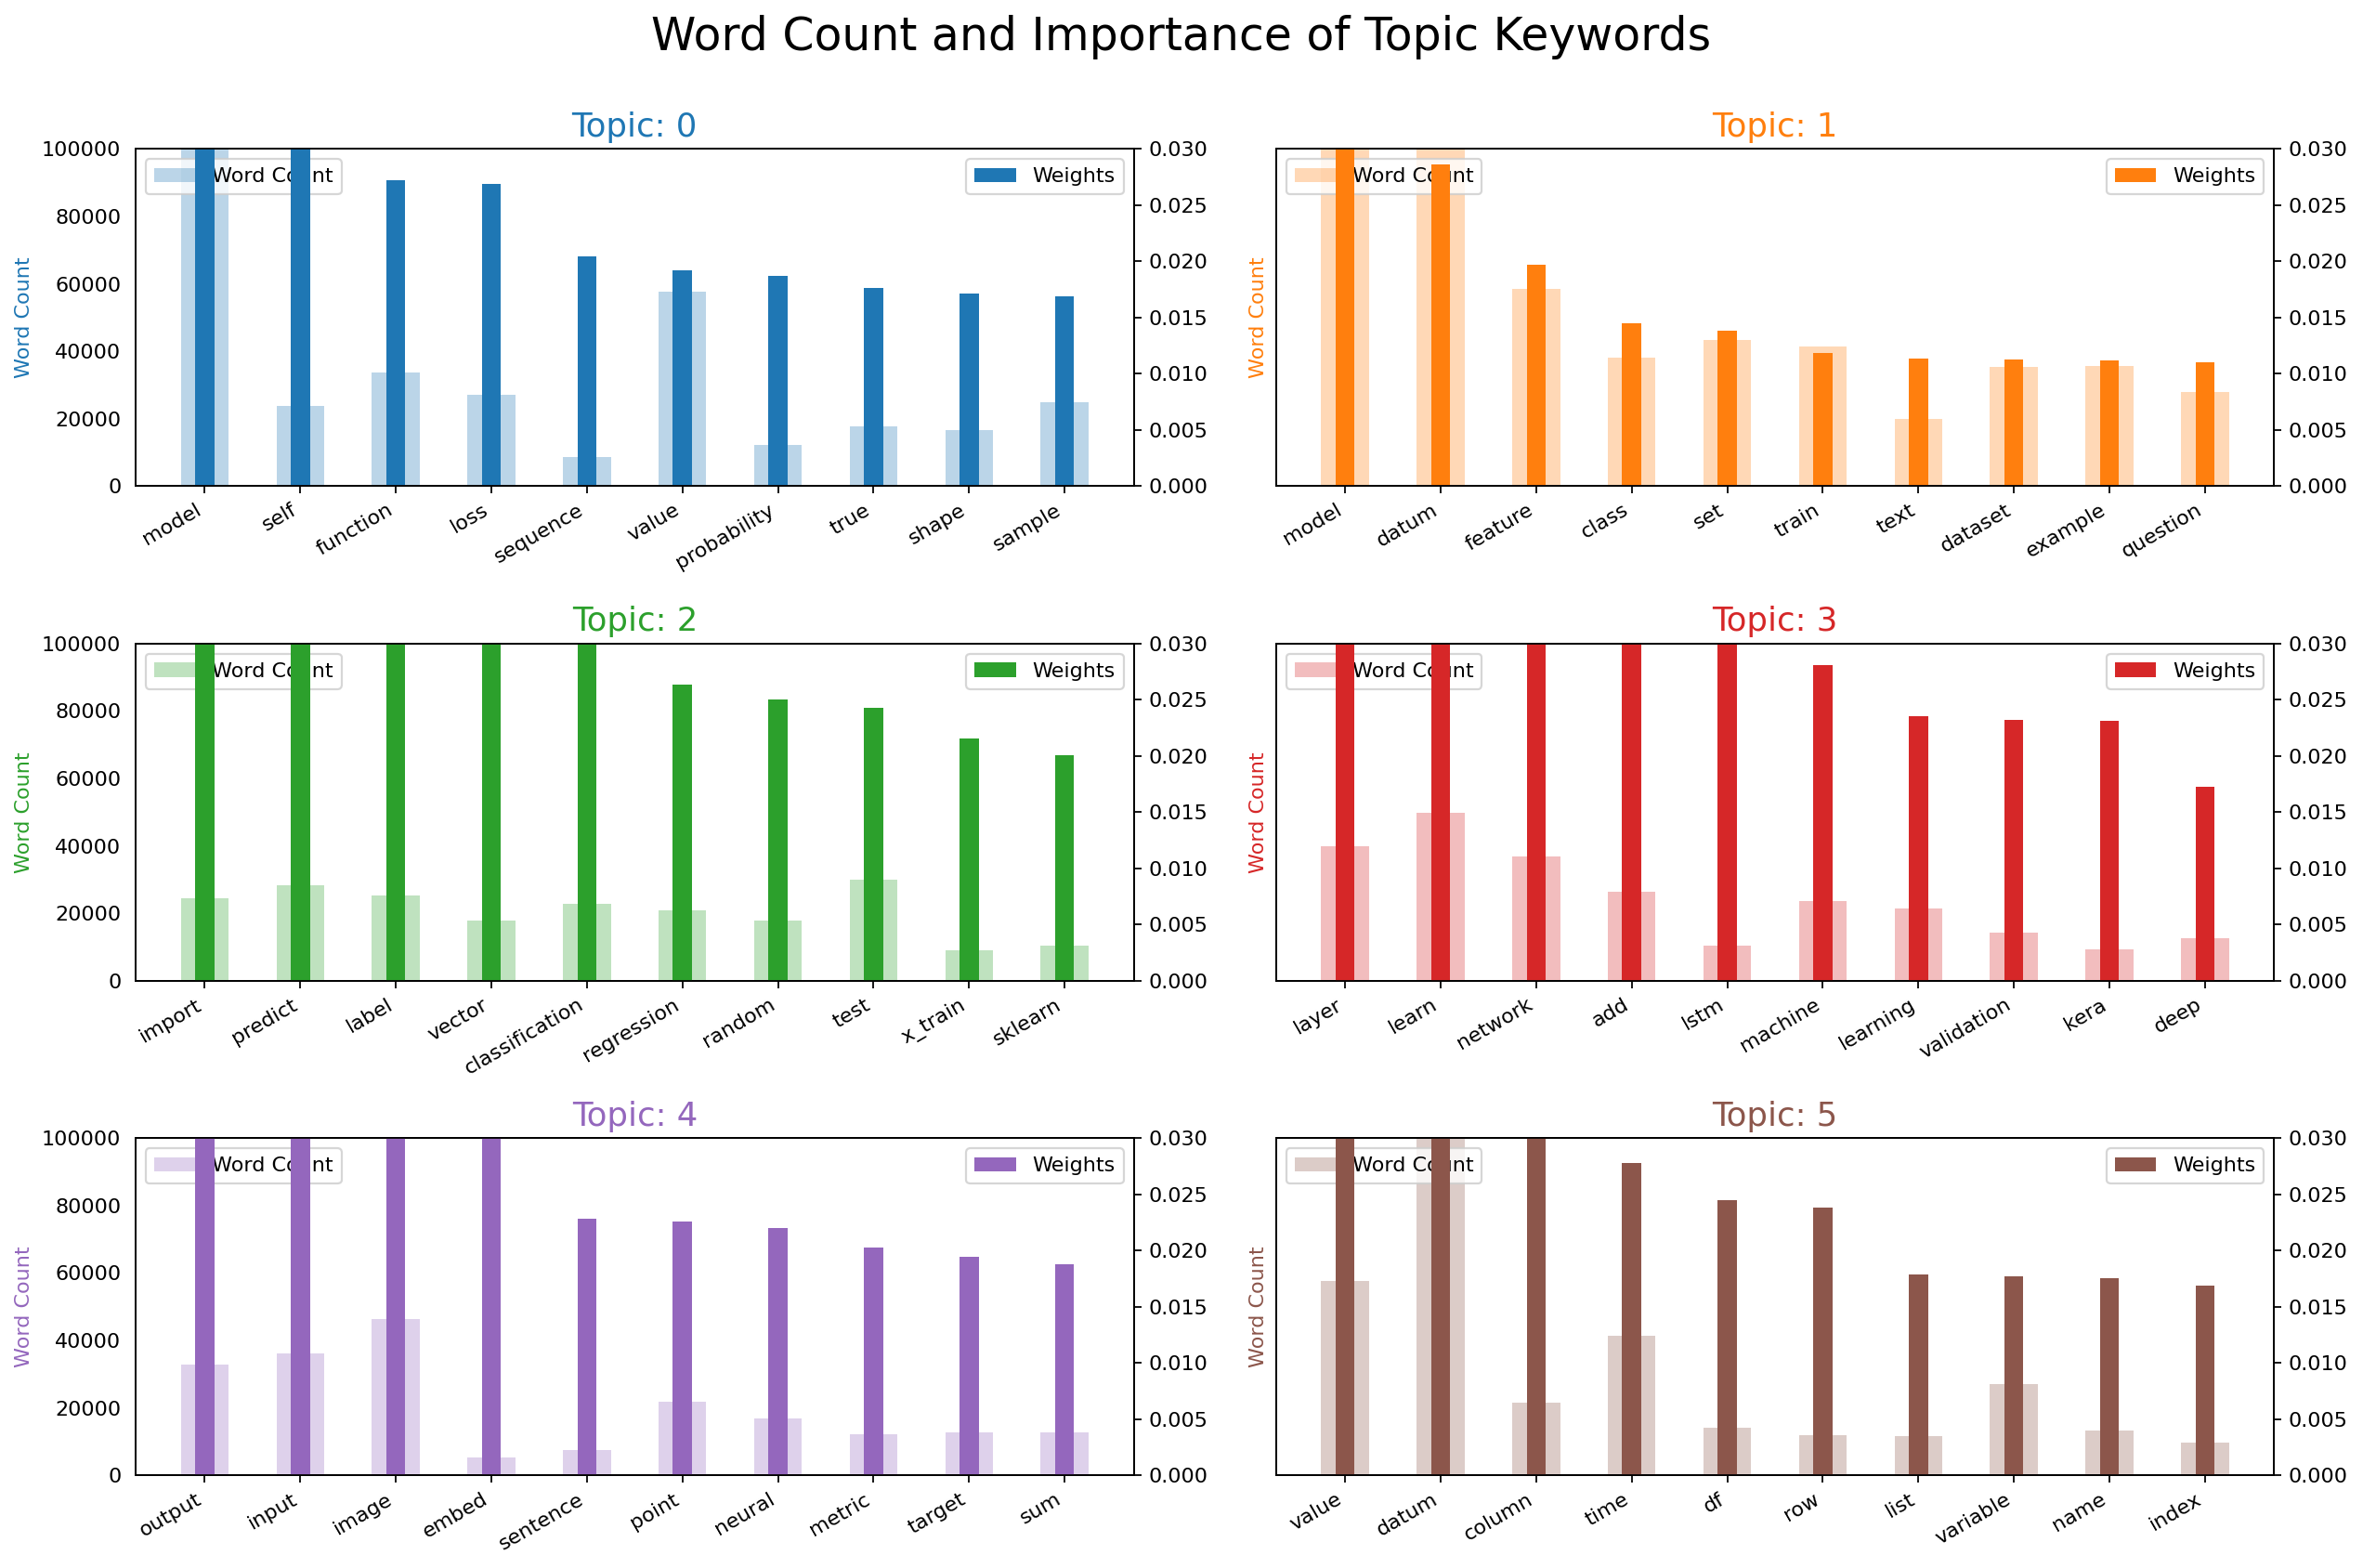

In [49]:

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 100000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## 13. Sentence Chart Colored by Topic.

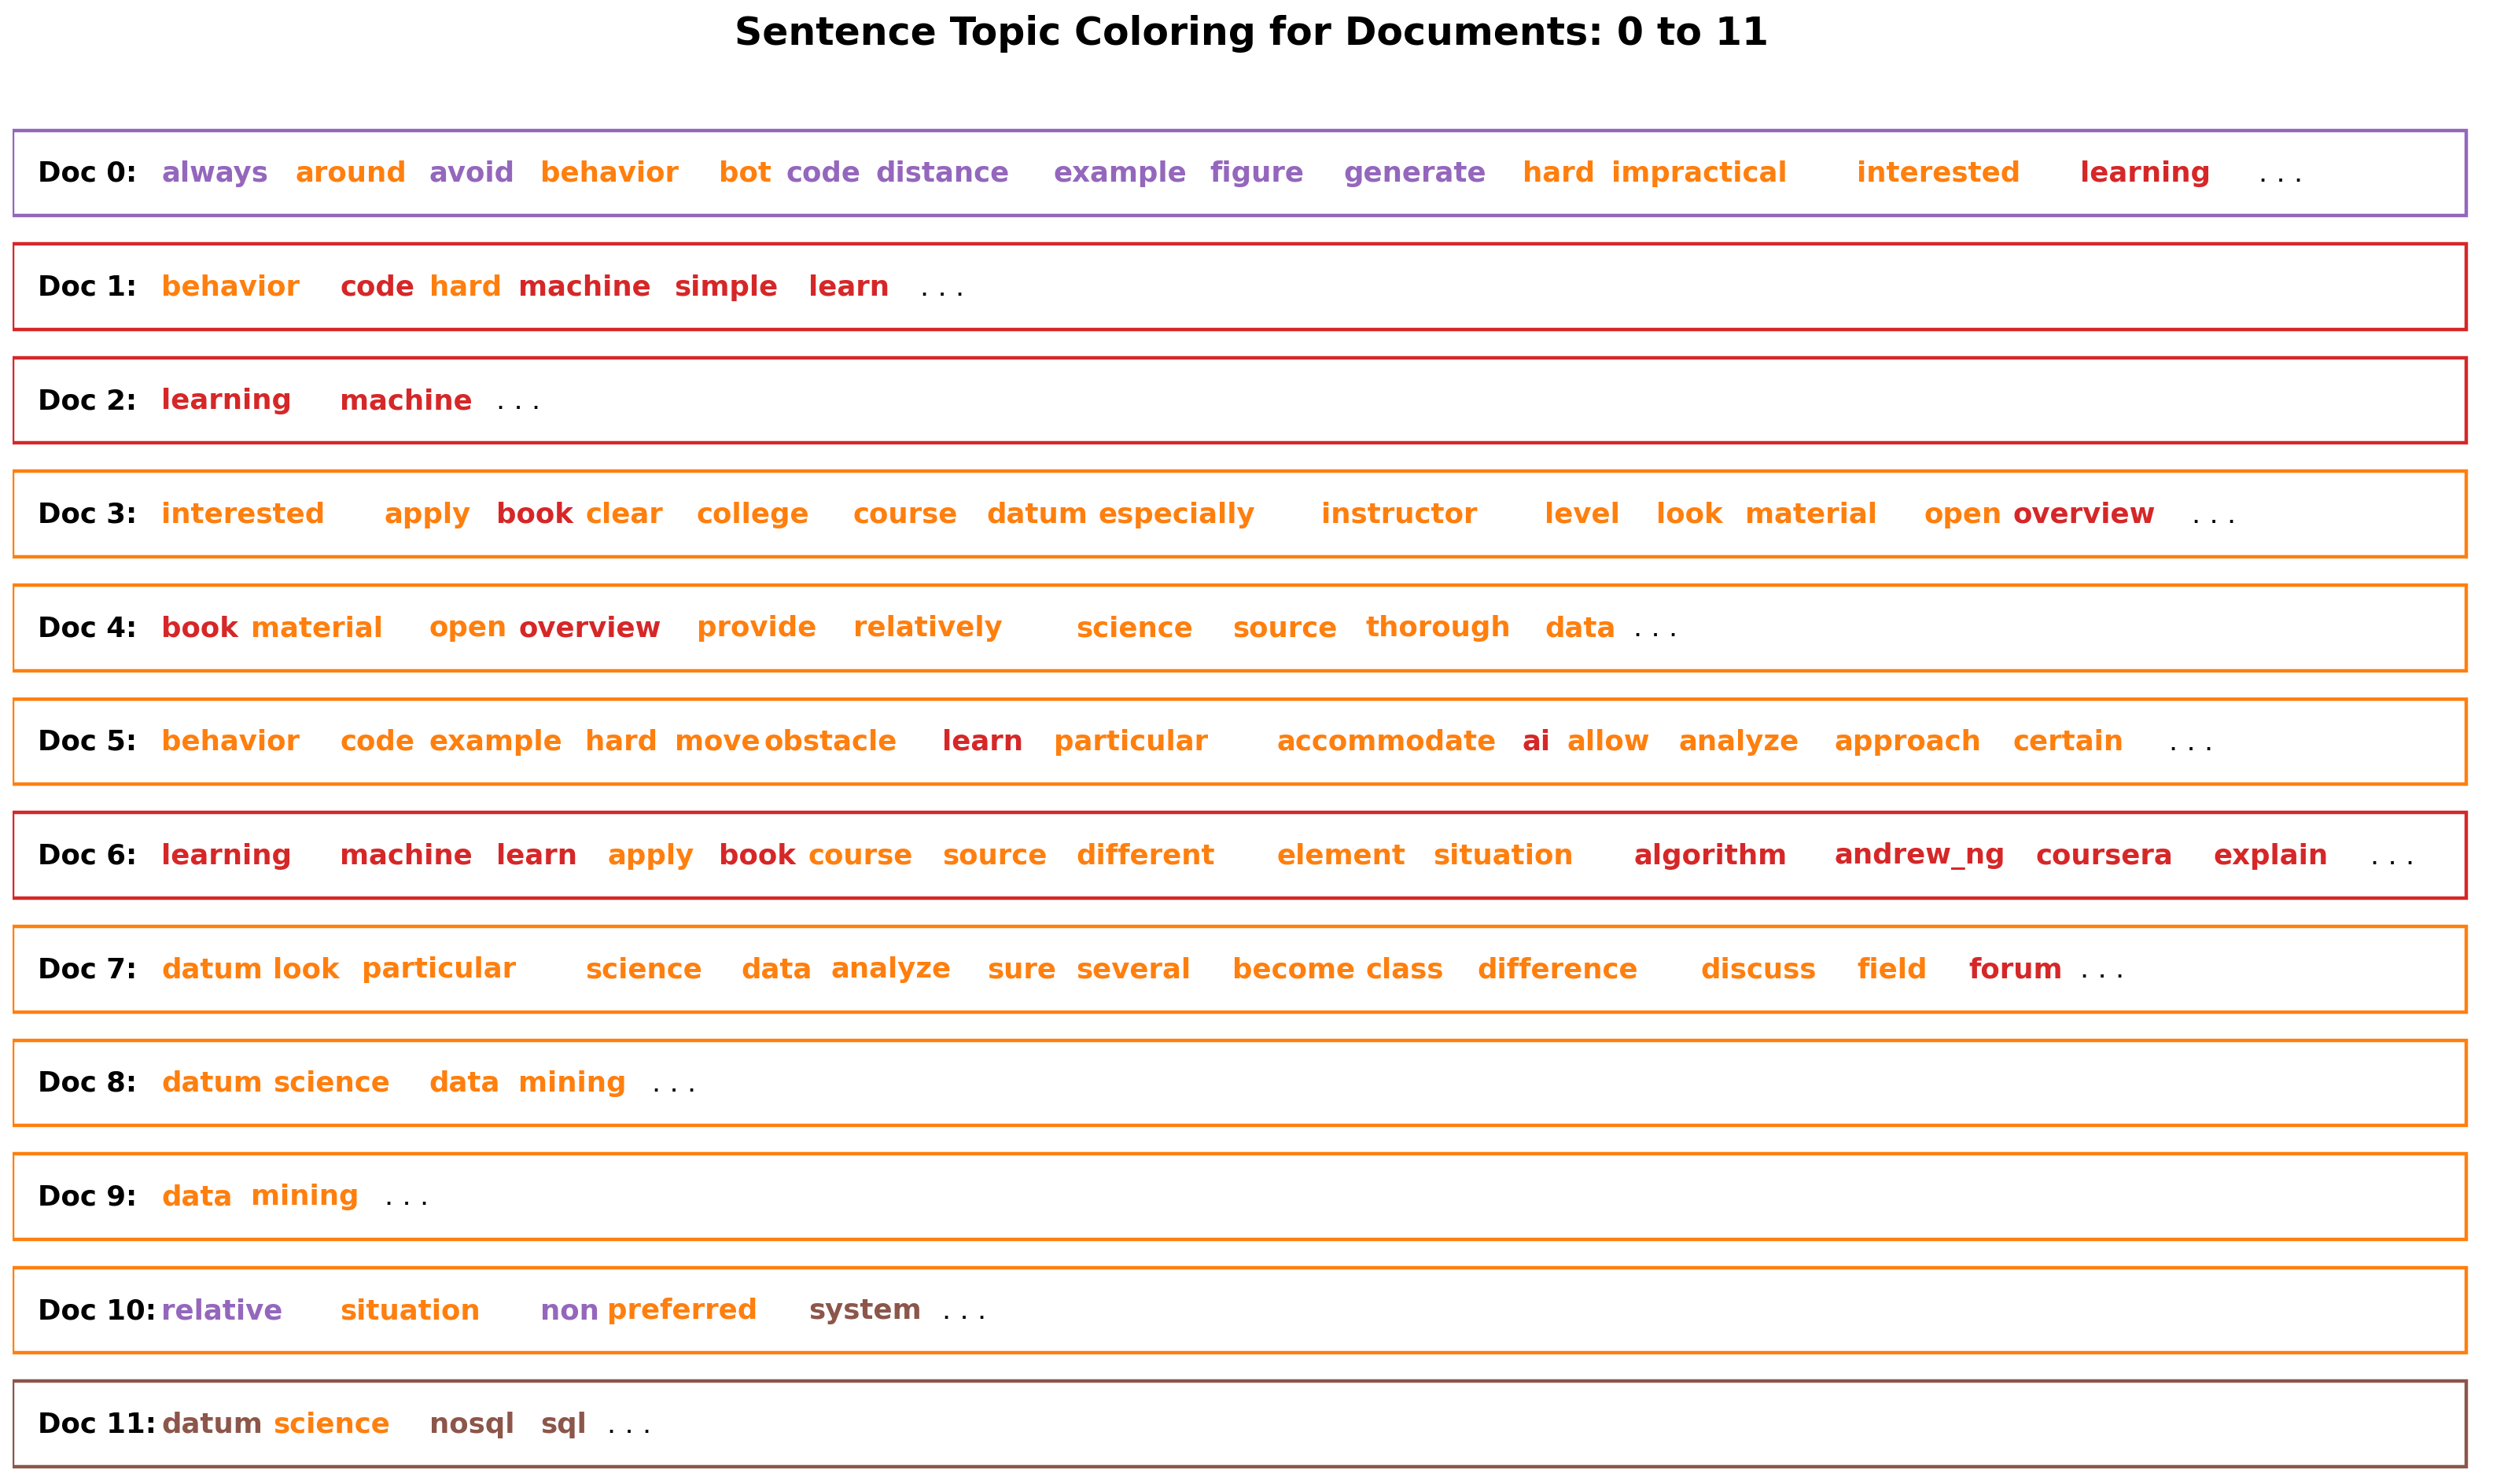

In [50]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

## 14. The most discussed topics in the documents

In [51]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

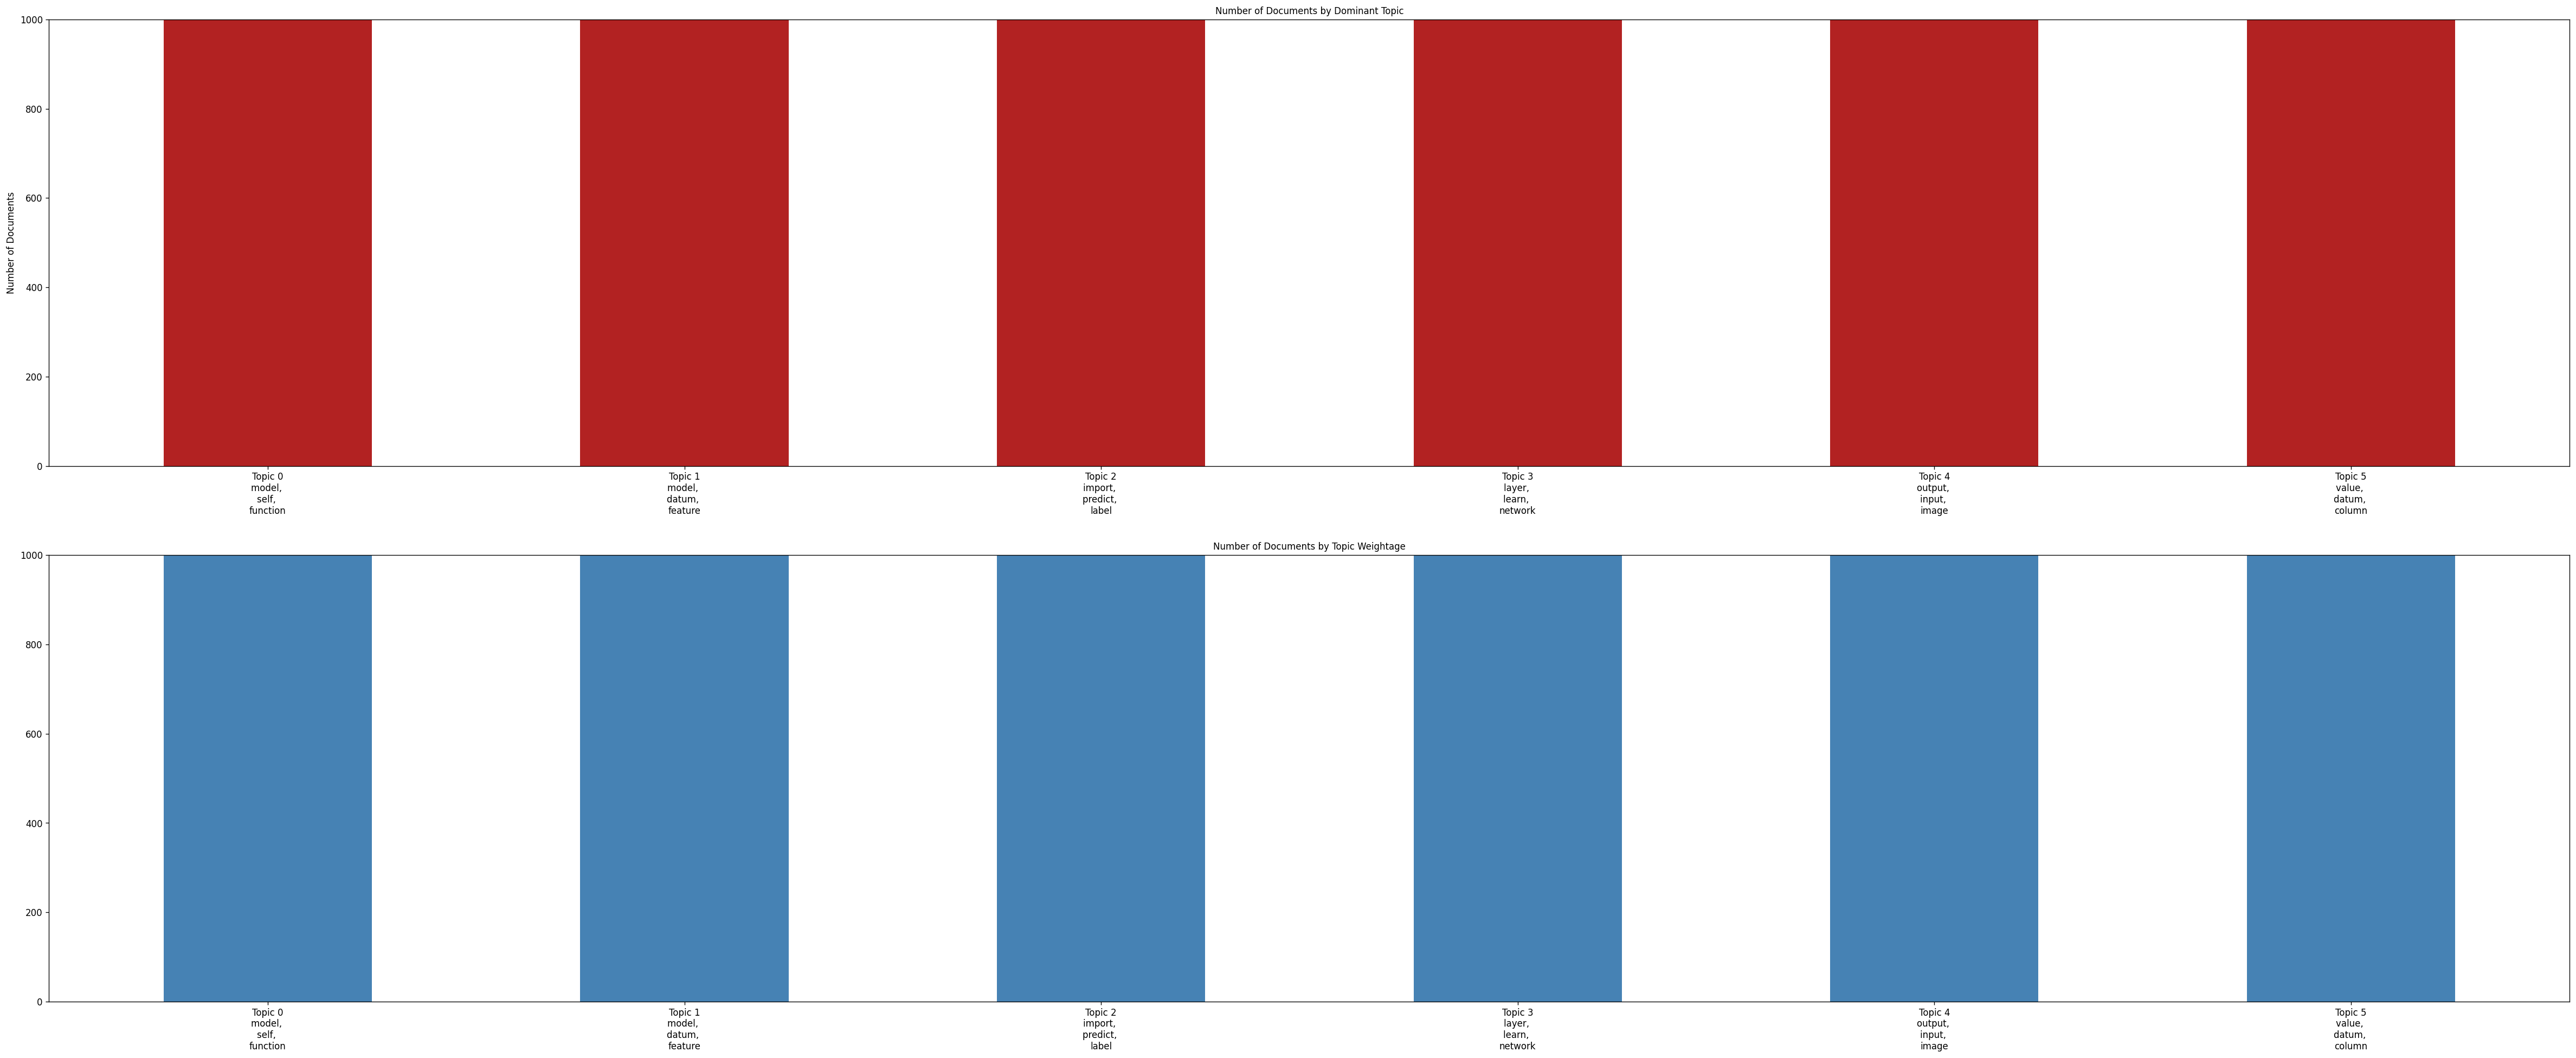

In [52]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 20), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## 15. t-SNE Clustering Chart

In [53]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 147143 samples in 0.550s...
[t-SNE] Computed neighbors for 147143 samples in 13.239s...
[t-SNE] Computed conditional probabilities for sample 1000 / 147143
[t-SNE] Computed conditional probabilities for sample 2000 / 147143
[t-SNE] Computed conditional probabilities for sample 3000 / 147143
[t-SNE] Computed conditional probabilities for sample 4000 / 147143
[t-SNE] Computed conditional probabilities for sample 5000 / 147143
[t-SNE] Computed conditional probabilities for sample 6000 / 147143
[t-SNE] Computed conditional probabilities for sample 7000 / 147143
[t-SNE] Computed conditional probabilities for sample 8000 / 147143
[t-SNE] Computed conditional probabilities for sample 9000 / 147143
[t-SNE] Computed conditional probabilities for sample 10000 / 147143
[t-SNE] Computed conditional probabilities for sample 11000 / 147143
[t-SNE] Computed conditional probabilities for sample 12000 / 147143
[t-SNE] Computed conditional probab

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.781975
[t-SNE] KL divergence after 1000 iterations: 3.210224


Loading BokehJS ...

## 16. pyLDAVis

In [54]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.216098  0.002265       1        1  44.239315
0      0.089072  0.113940       2        1  14.808616
5      0.260362  0.014470       3        1  11.472692
4     -0.178468  0.088224       4        1   9.961365
2     -0.125399 -0.410513       5        1   9.886247
3     -0.261666  0.191614       6        1   9.631764, topic_info=               Term           Freq          Total Category  logprob  loglift
79            model  172691.000000  172691.000000  Default  30.0000  30.0000
2482          layer   55771.000000   55771.000000  Default  29.0000  29.0000
29            learn   51938.000000   51938.000000  Default  28.0000  28.0000
35            datum  122729.000000  122729.000000  Default  27.0000  27.0000
1066           self   47834.000000   47834.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
1023  documentation    3407.098603    3407.954836   Topic6  -5.3397   2.3399
206             add   25862.852997   28466.943098   Topic6  -3.3128   2.2442
916           cross    6236.501467   11675.680300   Topic6  -4.7352   1.7130
219             com    9915.738749   37299.635556   Topic6  -4.2715   1.0152
3343           bias    4721.544892    6863.300467   Topic6  -5.0135   1.9661

[256 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2354      5  0.999951    accuracy
3149      2  0.999974  activation
206       3  0.091439         add
206       6  0.908527         add
101       6  0.999894   algorithm
...     ...       ...         ...
293       6  0.034539        work
4519      5  0.999815         x_t
4520      5  0.999973     x_train
4522      5  0.999876     y_train
131       1  0.999897        year

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 5, 3, 4])

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
